<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Bayesian_Optimal_Pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bayesian Optimal Pricing using PyMC
PyMC  
1.   PyMC is a probabilistic programming library for Python
2.   PyMC allows users to build Bayesian models with a simple Python API
3.   Users can fit Bayesian models using Markov chain Monte Carlo (MCMC) methods


#References:
https://www.pymc.io/welcome.html

https://austinrochford.com/posts/intro-prob-prog-pymc.html

https://cscherrer.github.io/post/max-profit/
https://datasciencejuliahackers.com/optimal-pricing.html#maximizing-profit

#A Motivating Example: Linear Regression



In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import xarray as xr
from pymc import model_to_graphviz

az.style.use("arviz-darkgrid")

RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

# Number of observed data
N_observed = 200
N_sample_prior_predictive = 50
N_posterior = 1000
N_posterior_predictive = 1000

APPLY_STANDARDIZE = False

print(f"Running on PyMC v{pm.__version__}")

In [ ]:
true_a, true_b = -5.5, 3.0
predictor_mean, predictor_scale = 3.0, 1.0

predictor = rng.normal(loc=predictor_mean, scale=predictor_scale, size=N_observed)
true_mu = true_a + true_b * predictor
true_std = 2.0

outcome = rng.normal(loc=true_mu, scale=true_std, size=N_observed)

if APPLY_STANDARDIZE:
  def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

  def de_standarize():
    a1 = idata.posterior['a'].mean().values
    b1 = idata.posterior['b'].mean().values
    xmean = predictor.mean()
    ymean = outcome.mean()
    xstd = predictor.std()
    ystd = outcome.std()

    b = b1*ystd/xstd
    a = (a1 + ymean/ystd - b*xmean/ystd)*ystd
    return a, b

  predictor_scaled = standardize(predictor)
  outcome_scaled = standardize(outcome)
  #  print(true_a, true_b, de_standarize())

else:
  predictor_scaled = predictor
  outcome_scaled = outcome

print(f"predictor.mean = {predictor.mean():.2f}, predictor.std={predictor.std():.2f}, \
outcome.mean={outcome.mean():.2f}, outcome.std={outcome.std():.2f}")

In [ ]:
az.plot_dist(
    predictor,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="predictor",
)
az.plot_dist(
    outcome,
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="outcome",
)
plt.xticks(rotation=45);

In [ ]:
# Create two subplots and unpack the output array immediately
_, (ax1, ax2) = plt.subplots(1, 2, layout='constrained', sharey=False)
ax1.scatter(predictor, outcome)
ax1.set_title('original')
ax1.set_xlabel('predictor')
ax1.set_ylabel('outcome')

if APPLY_STANDARDIZE:
  ax2.scatter(predictor_scaled, outcome_scaled)
  ax2.set_title('standarized')
  ax2.set_xlabel('predictor')


The final line of the model defines obs, the sampling distribution of the outcomes in the dataset as: \

  pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)

This is a special case of a stochastic variable that we call an observed stochastic, and represents the **data likelihood of the model**. \
It is identical to a standard stochastic, except that its **observed** argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a ndarray or DataFrame object.



In [ ]:
# define model and
# run sample_prior_predictive
with pm.Model() as model_1:
    # Priors for unknown model parameters
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)
    sigma = pm.Exponential("sigma", 1.0)

    # Expected value of outcome
    mu = a + b * predictor_scaled
    #This creates a deterministic random variable, that is completely determined by its parents’ values.

    # Likelihood (sampling distribution) of observations
    pm.Normal("obs", mu=mu, sigma=sigma, observed=outcome_scaled)

model_to_graphviz(model_1)

In [ ]:
with model_1:
      idata = pm.sample_prior_predictive(samples=N_sample_prior_predictive, random_seed=rng)

In [ ]:
idata

In [ ]:
_, ax = plt.subplots()
#xarray
x = xr.DataArray(np.linspace(-2, 2, N_sample_prior_predictive), dims=["plot_dim"])
prior = idata.prior
y = prior["a"] + prior["b"] * x

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

In [ ]:
#Draw samples from the posterior using the given step methods.
# Do use idata.extend() to add posterior data structure
with model_1:
  idata.extend(pm.sample(N_posterior, tune=2000, random_seed=rng))

In [ ]:
idata

In [ ]:
with model_1:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)
idata


#Model Checking: step 1
A simple first step in model checking is to visually inspect our samples by looking at the traceplot for the univariate latent parameters to check for obvious problems. These names can be passed to plot_trace in the var_names argument.

In [ ]:
az.plot_trace(idata); #, var_names=["tau", "sigma", "c2"]


In [ ]:
print(true_a, true_b, true_std)
print(idata.posterior['a'].mean().values, idata.posterior['b'].mean().values, idata.posterior['sigma'].mean().values)

In [ ]:
idata.prior['a'].values.T.shape
#idata.prior_predictive

In [ ]:
plt.hist(idata.prior['a'].values.T);

In [ ]:
idata.posterior['a'].values.shape

In [ ]:
plt.hist(idata.posterior['a'].values.T);

In [ ]:
az.plot_forest(idata, var_names=["a"], combined=True, hdi_prob=0.95, r_hat=True);

In [ ]:
az.plot_forest(idata, var_names=["b"], combined=True, hdi_prob=0.95, r_hat=True);


In [ ]:
az.plot_forest(idata, var_names=["sigma"], combined=True, hdi_prob=0.95, r_hat=True);

#Model Checking: step 2
The next easy model-checking step is to see if the NUTS sampler performed as expected. An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribution. If it was not, one runs the risk of biased posterior estimates when parts of the posterior are not visited with adequate frequency. The plot shows two density estimates: one is the marginal energy distribution of the sampling run and the other is the distribution of the energy transitions between steps. This is all a little abstract, but all we are looking for is for the distributions to be similar to one another. Ours does not look too bad.

In [ ]:
az.plot_energy(idata);


Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters.




In [ ]:
#prior_predictive: For each observed data point, prior predictive draw N_sample_prior_predictive samples
print(idata.prior_predictive['obs'].shape)
for i in range(5):
  print(idata.prior_predictive['obs'][0, :, i].mean().values, idata.prior_predictive['obs'][0, :, i].std().values)

arviz.plot_ppc: \

observedbool, optional
Whether or not to plot the observed data. Defaults to True for group = posterior and False for group = prior.

group{“prior”, “posterior”}, optional
Specifies which InferenceData group should be plotted. Defaults to ‘posterior’. Other value can be ‘prior’.


In [ ]:
az.plot_ppc(idata,  group="prior");


In [ ]:
az.plot_ppc(idata, num_pp_samples=100);


In [ ]:
post = idata.posterior
mu_pp = post["a"] + post["b"] * xr.DataArray(predictor_scaled, dims=["obs_id"])

In [ ]:
post["a"].shape, predictor_scaled.shape, mu_pp.shape

In [ ]:
mu_pp.mean(axis=(0,1)).shape

In [ ]:
_, ax = plt.subplots()

ax.plot(
    predictor, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(predictor, idata.observed_data["obs"])
az.plot_hdi(predictor, idata.posterior_predictive["obs"])

ax.set_xlabel("Predictor (no stdz)")
ax.set_ylabel("Outcome (no stdz)");

We have a lot of data, so the uncertainty around the mean of the outcome is pretty narrow; but the uncertainty surrounding the outcome in general seems quite in line with the observed data.

#Bayesian Optimal Pricing

Bayes's Theorem states that:\
     **p(H|D) = p(D|H)*p(H)/p(D)**, where,

*   H is the hypothesis  
*   D is the observed data



*   p(H) represents the prior distribution, which is a probability distribution that incorporates results or information obtained before the experiment;
*   p(H|D) is the posterior distribution

*   p(D|H) is the likelihood function
*   p(D) is sometimes called the "marginal likelihood", because it is the likelihood of the data regardless of whether the hypothesis (or anything else) is true or not, and is sometimes referred to as the "normalising constant".



This prior is the most important difference that distinguishes Bayesian from frequentist.
While frequentists only use their own data in their analysis, Bayesians can incorporate the opinions of other experts, historical data, or a combination of both into their prior.
If new data is added after the posterior distribution is obtained, the posterior distribution is used again as a prior to generate another posterior distribution.
This is a more useful approach in the data era, as it allows for the accumulation of knowledge without revisiting all past data.



In [ ]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from pymc import model_to_graphviz
import xarray as xr


In [ ]:
# price and quantity
price_data = np.array([30, 35, 40, 45, 50])
quantity_data = np.array([153, 45, 25, 26, 24])

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10, 3))
ax1.plot(price_data, quantity_data, 'o-')
ax2.plot(np.log(price_data), np.log(quantity_data), 'o-')
fig.tight_layout()

The relationship between Q and P are often of the form:\
Q = a\*(P^c).\
For statistical analysis, it makes more sense to write this in terms of a conditional expectation,\
E[Q|P] = a\*(P^c). \
Taking the log of both sides makes this much more familiar:\
log(E[Q|P]) = log(a) + c*log(P). \

The right side is now a linear function of the unknowns
loga and c, so considering these as parameters gives us a generalized linear model. Conveniently, the reasonable assumption that Q is discrete and comes from independent unit purchases leads us to a Poisson distribution, which fits well with the log link.

Econometrically, this linear relationship in log-log space corresponds to constant price elasticity. This constant elasticity is just the parameter c, so fitting the model will also give us an estimate of the elasticity.



#Expressing this in PyMC3 is straightforward:


In [ ]:
# Prior non-informative: Cauchy vs Norm
import numpy as np
import scipy.stats as st
import arviz as az
plt.style.use('arviz-darkgrid')
x = np.linspace(-10, 10, 500)
alphas = [ 0., 0.]
betas = [1., 2.]
for a, b in zip(alphas, betas):
    pdf = st.cauchy.pdf(x, loc=a, scale=b)
    plt.plot(x, pdf, label=f'Cauchy: a={a}, b={b}')
    pdf = st.norm.pdf(x, loc=a, scale=b)
    plt.plot(x, pdf, label=f'Norm: a={a}, b={b}')
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [13]:
# Model of Poisson distribution: log(E[Q|P]) = log(a) + c*log(P)
with pm.Model() as m:
    # Priors for unknown model parameters
    loga_model = pm.Cauchy('loga', 0, 1)
    c_model = pm.Cauchy('c', -2, 1)

    # Expected value of outcome
    # log of quantity
    log_quantity_model = loga_model + c_model*np.log(price_data)
    # quantity
    quantity_mean_model = pm.Deterministic('quantity_mean', np.exp(log_quantity_model))
    # μ0 dim is (chain, draw, μ0_dim_0)
    # (chain=2, draw=1000) via pm.sample() args;
    # μ0_dim_0=5 as price has 5 elements;

    # Likelihood (sampling distribution) of observations
    qval = pm.Poisson('quantity', quantity_mean_model, observed=quantity_data)

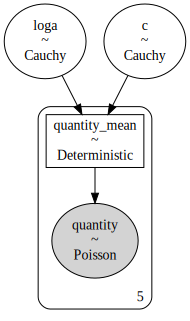

In [15]:
model_to_graphviz(m)

#Draw samples from the posterior using the given step methods:
**pymc.sample() args:**
1. draws: The number of samples to draw. Defaults to 1000.
2. chains: If None, then set to either cores or 2, whichever is larger.
3. tune: Number of iterations to tune, defaults to 1000.
4. step: A step function or collection of functions. By default the NUTS step method will be used, if appropriate to the model.

In [16]:
#Draw samples from the posterior
with m:
    trace = pm.sample(draws=500)

In [17]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [18]:
pm.summary(trace)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loga,19.139,1.498,16.466,21.862,0.228,0.163,47.0,55.0,1.08
c,-4.200,0.423,-4.972,-3.445,0.063,0.045,49.0,45.0,1.08
quantity_mean[0],128.942,10.849,109.423,149.606,1.492,1.061,49.0,216.0,1.05
quantity_mean[1],67.375,4.073,60.474,75.457,0.139,0.098,862.0,747.0,1.00
quantity_mean[2],38.530,3.350,32.460,45.125,0.261,0.188,176.0,284.0,1.02
quantity_mean[3],23.597,3.021,18.278,29.548,0.338,0.245,88.0,89.0,1.05
quantity_mean[4],15.251,2.582,11.222,20.803,0.320,0.235,74.0,65.0,1.06


This gives us the posterior mean and standard deviation, along with some other useful information:


*   mc_error estimates simulation error by breaking the trace into batches, computing the mean of each batch, and then the standard deviation of these means.
*   hpd_* gives highest posterior density intervals. The 2.5 and 97.5 labels are a bit misleading. There are lots of 95% credible intevals, depending on the relative weights of the left and right tails. The 95% HPD interval is the narrowest among these 95% intervals.


*   n_eff gives the effective number of samples. We took 2000 samples, but there are some significant autocorrelations. For example, our samples from the posterior of c have about as much information as if we had taken 511 independent samples.
*   Rhat is sometimes called the potential scale reduction factor, and gives us a factor by which the variance might be reduced, if our MCMC chains had been longer. It's computed in terms of the variance between chains vs within each chain. Values near 1 are good.









In [ ]:
az.plot_trace(trace);


In [ ]:
az.plot_forest(trace, var_names=['loga'])

In [ ]:
az.plot_forest(trace, var_names=['c'])

In [ ]:
az.plot_forest(trace, var_names=['μ0'])

#Posterior Predictive Checks
#1. sample_posterior_predictive
Generate forward samples for var_names, conditioned on the posterior samples of variables found in the trace.

This method can be used to perform different kinds of model predictions, including posterior predictive checks.


The trace we found is a sample from the joint posterior distribution of the parameters. Instead of a point estimate, we have a sample of "possible worlds" that represent reality. To perform inference, we query each and aggregate the results.



In [19]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)
with m:
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=rng)

In [ ]:
trace

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


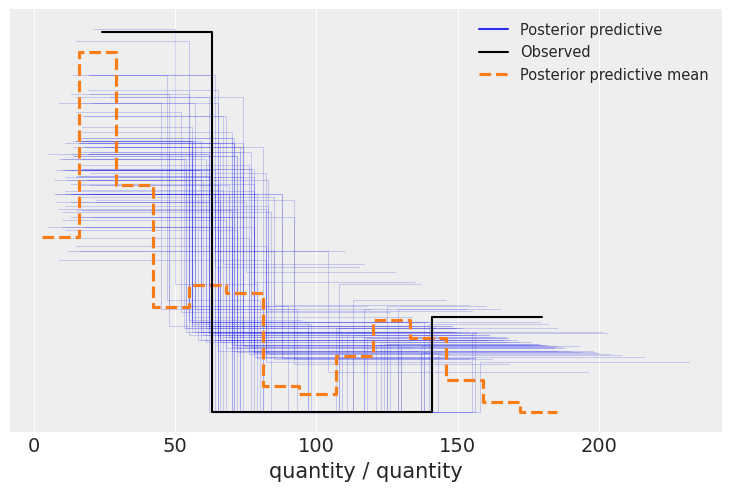

In [20]:
az.plot_ppc(trace, num_pp_samples=100);


In [ ]:
plt.plot(trace.posterior.loga, trace.posterior.c, '.');

In [24]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

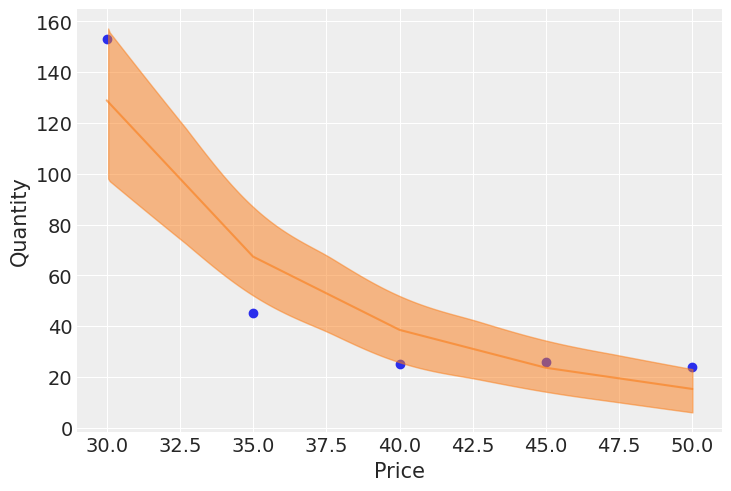

In [25]:
post = trace.posterior
mu_pp = np.exp(post["loga"] + post["c"] * xr.DataArray(np.log(price_data), dims=["obs_id"]))
#mu_pp = np.exp(post["loga"] + post["c"] * xr.DataArray(np.log(price), dims=["obs_id"]))

_, ax = plt.subplots()

ax.plot(
    price_data, mu_pp.mean(("chain", "draw")), label="Mean outcome", color="C1", alpha=0.6
)
ax.scatter(price_data, trace.observed_data["quantity"])
az.plot_hdi(price_data, trace.posterior_predictive["quantity"])

ax.set_xlabel("Price")
ax.set_ylabel("Quantity");

#Posterior Predictive Checks
The trace we found is a sample from the joint posterior distribution of the parameters. \  
Instead of **a point estimate**, we have a sample of "possible worlds" that represent reality. \  
To perform inference, we query each and aggregate the results.


In [81]:
def predict_quantity(price_new):
  #define the price points for which to calculate the predicted quantity using the inferred parameters

  # reshape inferred parameters from shape (chain, draw) to (1, chain*draw) to allow numpy array broadcasting
  loga = np.array(trace.posterior.loga).reshape(1, -1)
  c = np.array(trace.posterior.c).reshape(1, -1)

  #predicted quantity:
  # p of shape (num_price_points,1)
  # c of shape (1, chain*draw)
  # quantity
  quantity_est = np.exp(loga + c*np.log(price_new))
  print(price_new.shape, loga.shape, c.shape, quantity_est.shape)
  # log(E[quantity | price]) = loga + c*Price
  # E[quantity | price] = exp(loga + c*Price)
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(price_new, quantity_est, 'k.', alpha=0.01);
  ax.plot(price_data, quantity_data,'o', c='C1');
  ax.set_yscale('log')
  fig.tight_layout()
  plt.grid(True)

  for k in range(quantity_est.shape[0]):
    print(f'The quantity at price {price_new[k]} has: \
      min={np.min(quantity_est[k,:]):.1f}, \
      max={np.max(quantity_est[k,:]):.1f}, \
      std={np.std(quantity_est[k,:]):.1f}, \
      mean={np.mean(quantity_est[k,:]):.1f}')

  return quantity_est

In [ ]:
import scipy
#plt.boxplot(scipy.stats.poisson.cdf(q0,mu=t['μ0']));
plt.boxplot(scipy.stats.poisson.cdf(quantity_data, mu=np.array(trace.posterior.quantity_mean).reshape(-1, 1)));

#Optimization
We're almost there! Suppose we have a per-unit cost of $20. Then we can calculate the expected profit for each realization:

With a few array indexing tricks, we can then calculate the price that maximizes the overall expected profit (integrating over all parameters):


In [65]:
#profit
def calc_profit(price, cost, quantity):
  profit = (price - cost).reshape(-1,1) * quantity # + fixed_cost
  return profit

def calc_profit_0(price, cost, quantity):
  profit = (price - cost) * quantity # + fixed_cost
  return profit

(5,) (5,) (5,)
(5, 1000) (5, 1000) (5,)


In [193]:
def profit_opt(price_new, cost_unit, quantity_est):
  print(f'Inside profit_opt(): cost_unit={cost_unit}')
  profit = calc_profit(price_new, cost_unit, quantity_est)

  # find the price giving the maximum profit
  profit_mean = np.mean(profit,1)
  profit_std = np.std(profit,1)
  pmax = price_new[np.argmax(profit_mean)] # profit
  print(f' profit_mean.shape={profit_mean.shape}')
  print(f' quantity_est.shape={quantity_est.shape}')
  print(f'With data as:\n price={price_data} \n predicted quantity={quantity_data}')
  print(f'*** When cost per unit is {cost_unit}, the optimal price for max profit = {pmax} ***')
  # plot the price_new vs mean profit
  price_new = price_new.reshape(-1, )
  fig, ax = plt.subplots(figsize=(15, 5))

  ax.plot(price_new, np.mean(quantity_est, axis=1), 'y-*', lw=1, label="quantity mean");
  ax.plot(price_new, quantity_est, 'y.');

  ax.plot(price_new, profit, 'k.', alpha=0.01);
  ax.plot(price_new, profit_mean, c='C1', lw=2, label="$\mathbb{E}[\pi|P]$");

  ax.fill_between(price_new, (profit_mean - profit_std), (profit_mean + profit_std), alpha=0.1, color='C1')
  ax.plot(price_new, (profit_mean + profit_std).T, c='C1', lw=1, label="$\mathbb{E}[\pi|P]\ \pm$1 sd");
  ax.plot(price_new, (profit_mean - profit_std).T, c='C1', lw=1);
  ax.vlines(pmax, np.min(profit_mean), np.max(profit_mean), colors='C2', linestyles='dashed', label="argmax$_P\ \mathbb{E}[\pi|P]$")
  ax.vlines(cost_unit, np.min(profit_mean), np.max(profit_mean), colors='C0', linestyles='dashed', label="cost per unit")
  #ax.set_yscale('log')

  plt.ylim(-100, np.max(profit)*1.1);
  plt.xlabel("Price")
  plt.ylabel("Profit")
  plt.title(f'Profit vs price when cost per unit={cost_unit}: optimal price for max profit = {pmax}')

  plt.legend();
  plt.grid(True)
  #fig.tight_layout()

In [ ]:
num_new_prices = 101
price_new = np.linspace(20, 120, num=num_new_prices).reshape(-1, 1) #default num=50
quantity_est = predict_quantity(price_new)

Inside profit_opt(): cost_unit=20.0
 profit_mean.shape=(101,)
 quantity_est.shape=(101, 1000)
With data as:
 price=[30 35 40 45 50] 
 predicted quantity=[153  45  25  26  24]
*** When cost per unit is 20.0, the optimal price for max profit = [26.] ***


Inside profit_opt(): cost_unit=21.0
 profit_mean.shape=(101,)
 quantity_est.shape=(101, 1000)
With data as:
 price=[30 35 40 45 50] 
 predicted quantity=[153  45  25  26  24]
*** When cost per unit is 21.0, the optimal price for max profit = [27.] ***


Inside profit_opt(): cost_unit=22.0
 profit_mean.shape=(101,)
 quantity_est.shape=(101, 1000)
With data as:
 price=[30 35 40 45 50] 
 predicted quantity=[153  45  25  26  24]
*** When cost per unit is 22.0, the optimal price for max profit = [29.] ***


Inside profit_opt(): cost_unit=23.0
 profit_mean.shape=(101,)
 quantity_est.shape=(101, 1000)
With data as:
 price=[30 35 40 45 50] 
 predicted quantity=[153  45  25  26  24]
*** When cost per unit is 23.0, the optimal price for max profi

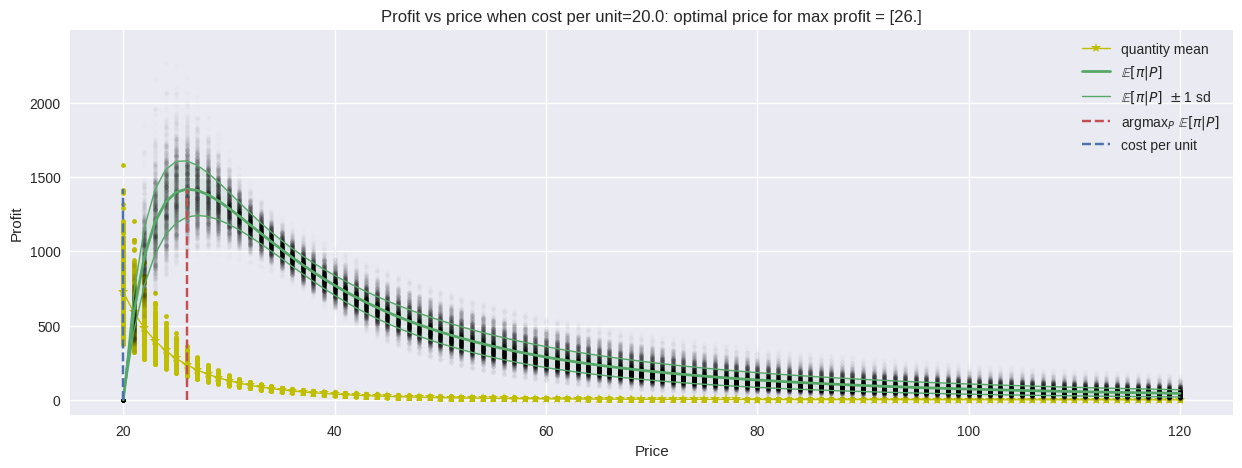

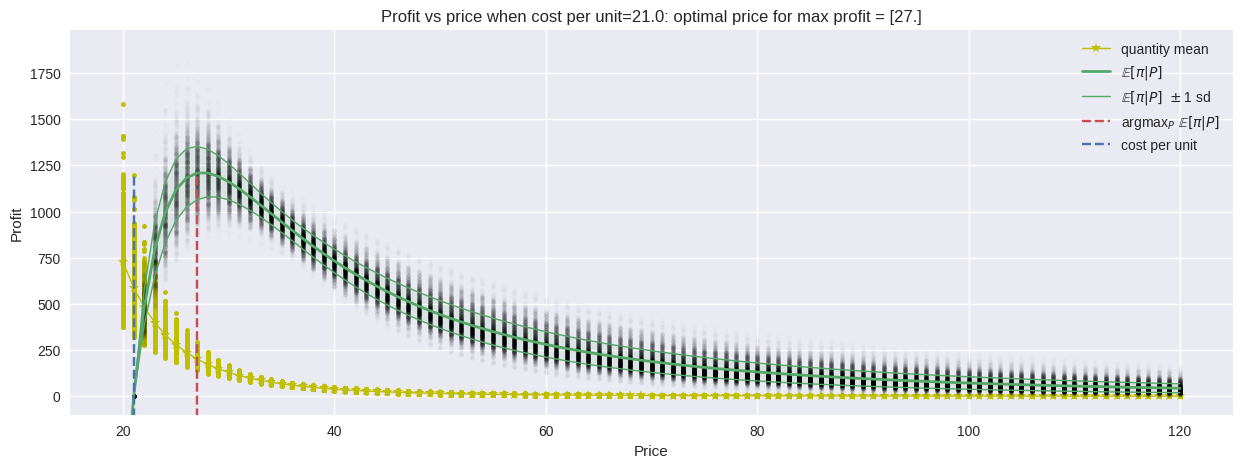

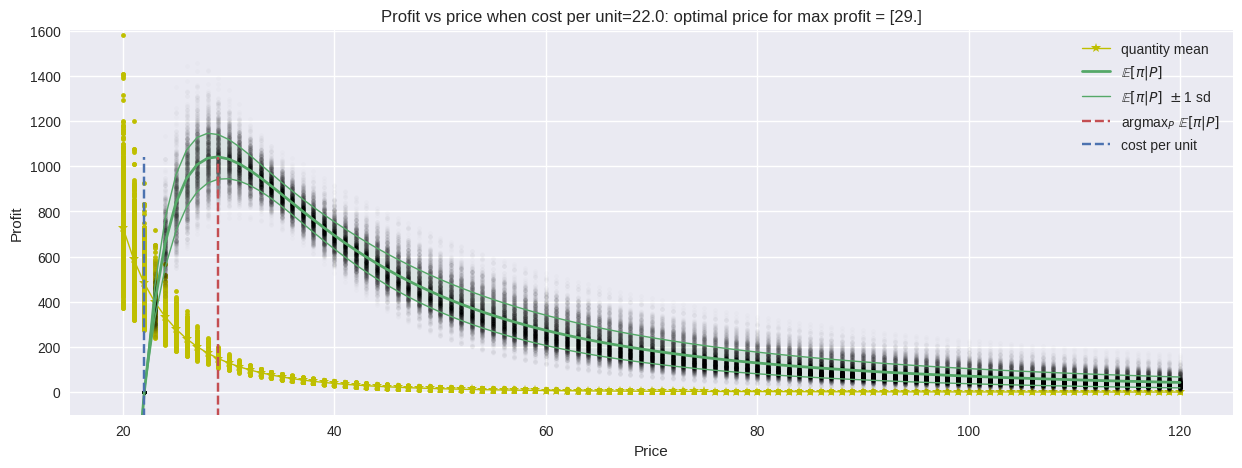

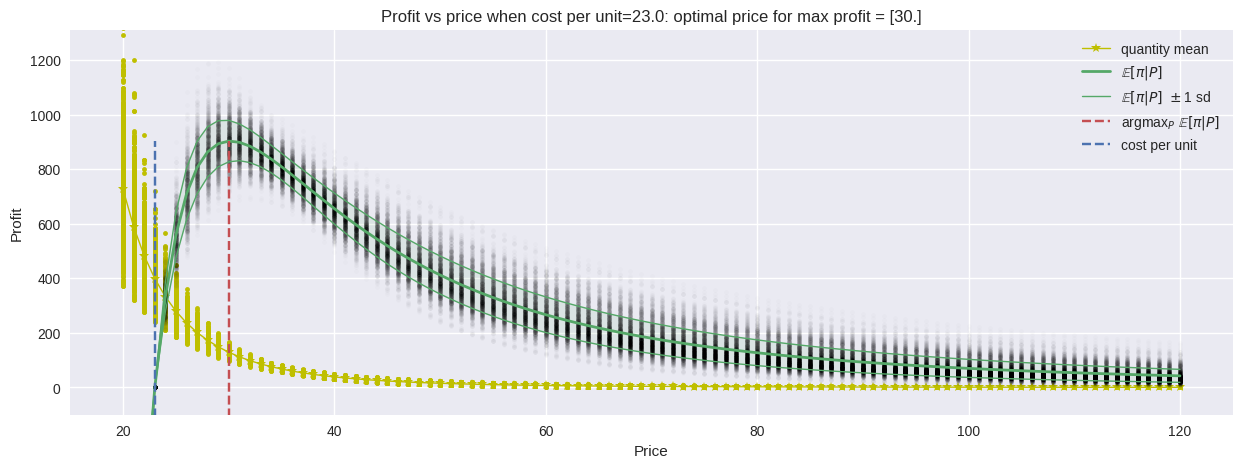

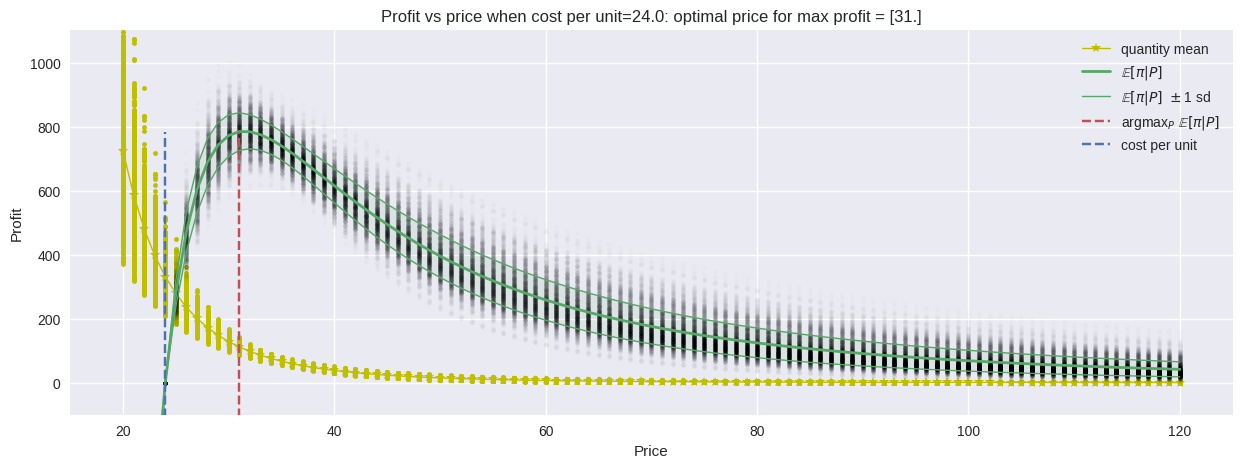

In [195]:
for cost_delta in range(0, 5, 1):
  cost_unit = np.min(price_new) + cost_delta
  profit_opt(price_new, cost_unit, quantity_est)
  print('\n')

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, sharex=True)
ax[0].plot(p, calc_profit(p, k, μ), alpha=0.01);
ax[0].plot(price, calc_profit_0(price, k, quantity));
ax[1].plot(price, calc_profit_0(price, k, quantity));

Observations:
1. When price=[30 35 40 45 50]
 quantity=[53  45  25  26  24]\
This suggests an optimal price of 51;

2. price=[30 35 40 45 50]
 quantity=[153  45  25  26  24]\
This suggests an optimal price of 25;




Questions:
1. Will the risk of losing a customer needed to be modelled explicitly? \
   Or it is already included in the model by the quantitydata?

#Reparameterization

The trouble came from off-center
logprice values, so let's try taking that into account in the model. A quick adjustment does the job:

In [ ]:
with pm.Model() as m2:
    α = pm.Cauchy('α',0,5)
    β = pm.Cauchy('β',0,5)
    logμ0 = α + β * (np.log(price) - np.log(price).mean())
    μ0 = pm.Deterministic('μ0',np.exp(logμ0))
    qval = pm.Poisson('quantity',μ0,observed=quantity)

In [ ]:
model_to_graphviz(m2)

Note that we've changed the names of the parameters, to keep things straight. If we wanted to transform between the two parameterizations, we could equate the two logμ0 expressions and solve the system of equations (constant terms equal, and logprice terms equal).



In [ ]:
with m2:
    t = pm.sample()
pm.summary(t)

In [ ]:
#There are a few other useful tools we can explore. Here's the trace plot:

pm.plot_trace(t);
#FutureWarning: The function `traceplot` from PyMC was an alias for `plot_trace` from ArviZ. It was removed in PyMC 4.0.
#Switch to `pymc.plot_trace` or `arviz.plot_trace`.


In [ ]:
import arviz

In [ ]:
arviz.plot_forest(t,var_names=['α','β'])
#FutureWarning: The function `forestplot` from PyMC was an alias for `plot_forest` from ArviZ.
#It was removed in PyMC 4.0. Switch to `pymc.plot_forest` or `arviz.plot_forest`.


In [ ]:
pm.plot_forest(t,var_names=['α','β'])


Posterior Predictive Checks
The trace we found is a sample from the joint posterior distribution of the parameters. Instead of a point estimate, we have a sample of "possible worlds" that represent reality. To perform inference, we query each and aggregate the results. So, for example...



In [ ]:
t

In [ ]:
t.posterior.α


In [ ]:
μ = np.exp(t.posterior.α + t.posterior.β)
μ.shape, p.shape, p.reshape(-1,1).shape, price.shape

In [ ]:
np.array(t.posterior.α).reshape(-1, 1)

In [ ]:
plt.plot(t.posterior.α, t.posterior.β, '.');

#Posterior Predictive Checks
The trace we found is a sample from the joint posterior distribution of the parameters. Instead of a point estimate, we have a sample of "possible worlds" that represent reality. To perform inference, we query each and aggregate the results. So, for example...

In [ ]:
# log(E[quantity | price]) = α + c*(Price-Price.mean)
# E[quantity | price] = exp(α + β*(Price-Price.mean))

p = np.linspace(25,55, num=2000)
#μ = np.exp(t.α + t.β * (np.log(p).reshape(-1,1) - np.log(price).mean()))
μ = np.exp(np.array(t.posterior.α).reshape(-1, 1) +
           np.array(t.posterior.β).reshape(-1, 1) * (np.log(p).reshape(-1,1) - np.log(price).mean()))

plt.plot(p, μ, c='k',alpha=0.1);
plt.plot(price, quantity, 'o', c='C1');

To be concise, I've left out some simple code like axis labels, etc. Here's the result.

In [ ]:
import matplotlib.pyplot as plt
import scipy

In [ ]:
np.array(t.posterior.μ0).shape, np.array(t.posterior.μ0).reshape(-1, 1).shape


In [ ]:
#The following boxplot makes this point more explicitly:

plt.boxplot(scipy.stats.poisson.cdf(quantity, mu=np.array(t.posterior.μ0).reshape(-1, 1)));

Optimization
We're almost there! Suppose we have a per-unit cost of $20. Then we can calculate the expected profit for each realization:



In [ ]:
 μ.shape

In [ ]:
k = 20
π = (p - k).reshape(-1,1) * μ


In [ ]:
π.shape, pmax, np.mean(π,1)

In [ ]:
π[:2], π[-3:]

In [ ]:
plt.plot(p, π, c='b')
#plt.plot(p, np.mean(π,1)-π, alpha=0.1, c='g');

With a few array indexing tricks, we can then calculate the price that maximizes the overall expected profit (integrating over all parameters):


In [ ]:

plt.plot(p,π,c='k',alpha=0.1);
plt.plot(p,np.mean(π,1).T,c='C1',lw=2,label="$\mathbb{E}[\pi|P]$");
plt.fill_between(p,(np.mean(π,1)-np.std(π,1)).T, (np.mean(π,1)+np.std(π,1)).T, alpha=0.1,color='C1')
plt.plot(p,(np.mean(π,1)+np.std(π,1)).T,c='C1',lw=1,label="$\mathbb{E}[\pi|P]\ \pm$1 sd");
plt.plot(p,(np.mean(π,1)-np.std(π,1)).T,c='C1',lw=1);
pmax = p[np.argmax(np.mean(π,1))]
plt.vlines(pmax,300,900,colors='C0',linestyles='dashed',label="argmax$_P\ \mathbb{E}[\pi|P]$")

plt.ylim(300,900);
plt.xlabel("Price $P$")
plt.ylabel("Profit $\pi$")

plt.legend();

#https://www.griddynamics.com/blog/dynamic-pricing-algorithms


In [ ]:
!pip install pymc

In [ ]:
import pymc as pm
import seaborn
import scipy.stats
import numpy as np

In [ ]:

d0 = [20, 28, 24, 20, 23]                # observed demand samples

with pm.Model() as m:
    d = pm.Gamma('theta', 1, 1)          # prior distribution
    pm.Poisson('d0', d, observed = d0)   # likelihood
    samples = pm.sample(10000)           # draw samples from the posterior

In [ ]:
np.array(samples.posterior.theta).reshape(-1,1)


In [ ]:
samples.posterior.theta.shape

In [ ]:
seaborn.distplot(samples.posterior.theta, fit=scipy.stats.gamma)
